In [1]:
import findspark
findspark.init()

import pandas as pd
from ast import literal_eval
import tensorflow as tf
from keras import regularizers
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, VectorAssembler
from elephas.spark_model import SparkModel
from elephas.ml import df_to_simple_rdd


import os
from pathlib import Path
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SparkSQL") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions",100)

In [3]:
movieData = pd.read_csv("../resources/movieData.csv", converters={'genres': literal_eval, 'production_countries': literal_eval, 'directors': literal_eval, 'actors': literal_eval})
movieData = movieData.drop(columns=['id', 'title', 'release_decade'])
movieData.head()

,Unnamed: 0,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,actors,directors
0,0,1976,R,114,"[drama, crime]",[US],8.2,808582.0,"[Robert De Niro 3748 ACTOR, Jodie Foster 14658...",[Martin Scorsese 3308 DIRECTOR]
1,1,1972,R,109,"[drama, action, thriller, european]",[US],7.7,107673.0,"[Jon Voight 10103 ACTOR, Burt Reynolds 13020 A...",[John Boorman 17727 DIRECTOR]
2,2,1975,PG,91,"[fantasy, action, comedy]",[GB],8.2,534486.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...","[Terry Jones 11475 DIRECTOR, Terry Gilliam 114..."
3,3,1967,0,150,"[war, action]","[GB, US]",7.7,72662.0,"[Lee Marvin 35196 ACTOR, Ernest Borgnine 1050 ...",[Robert Aldrich 1063 DIRECTOR]
4,4,1979,R,94,[comedy],[GB],8.0,395024.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...",[Terry Jones 11475 DIRECTOR]


In [4]:
movieData.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [5]:
movieData[["actors", "directors"]] = movieData[["actors", "directors"]].replace(0, None)
movieData.head()

,id,release_year,age_certification,runtime,genres,production_countries,imdb_score,imdb_votes,actors,directors
0,0,1976,R,114,"[drama, crime]",[US],8.2,808582.0,"[Robert De Niro 3748 ACTOR, Jodie Foster 14658...",[Martin Scorsese 3308 DIRECTOR]
1,1,1972,R,109,"[drama, action, thriller, european]",[US],7.7,107673.0,"[Jon Voight 10103 ACTOR, Burt Reynolds 13020 A...",[John Boorman 17727 DIRECTOR]
2,2,1975,PG,91,"[fantasy, action, comedy]",[GB],8.2,534486.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...","[Terry Jones 11475 DIRECTOR, Terry Gilliam 114..."
3,3,1967,0,150,"[war, action]","[GB, US]",7.7,72662.0,"[Lee Marvin 35196 ACTOR, Ernest Borgnine 1050 ...",[Robert Aldrich 1063 DIRECTOR]
4,4,1979,R,94,[comedy],[GB],8.0,395024.0,"[Graham Chapman 11472 ACTOR, John Cleese 1549 ...",[Terry Jones 11475 DIRECTOR]


In [6]:
movieSpark = spark.createDataFrame(movieData)

movieSpark.show()

+---+------------+-----------------+-------+--------------------+--------------------+----------+----------+--------------------+--------------------+
| id|release_year|age_certification|runtime|              genres|production_countries|imdb_score|imdb_votes|              actors|           directors|
+---+------------+-----------------+-------+--------------------+--------------------+----------+----------+--------------------+--------------------+
|  0|        1976|                R|    114|      [drama, crime]|                [US]|       8.2|  808582.0|[Robert De Niro 3...|[Martin Scorsese ...|
|  1|        1972|                R|    109|[drama, action, t...|                [US]|       7.7|  107673.0|[Jon Voight 10103...|[John Boorman 177...|
|  2|        1975|               PG|     91|[fantasy, action,...|                [GB]|       8.2|  534486.0|[Graham Chapman 1...|[Terry Jones 1147...|
|  3|        1967|                0|    150|       [war, action]|            [GB, US]|       7

In [7]:
movieSpark.createOrReplaceTempView('movie')
movieSpark.write.parquet('movie_parquet', mode='overwrite')
movieParquet = spark.read.parquet('movie_parquet')

In [8]:
movieParquet.createOrReplaceTempView('movieP')

In [9]:
movieGenreEx = spark.sql("""select id, explode(genres) as genre from movieP order by id""")
movieCountryEx = spark.sql("""select id, explode(production_countries) as country from movieP order by id""")
movieActorEx = spark.sql("""select id, explode(actors) as actor from movieP order by id""")
movieDirectorEx = spark.sql("""select id, explode(directors) as director from movieP order by id""")

In [10]:
movieCountryEx.groupBy('country').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|    1|   25|
|    2|   14|
|    3|    5|
|    4|    7|
|    5|    3|
|    6|    1|
|    7|    3|
|    8|    2|
|    9|    2|
|   10|    2|
|   11|    1|
|   12|    3|
|   13|    1|
|   15|    2|
|   17|    4|
|   19|    2|
|   20|    1|
|   28|    1|
|   30|    2|
|   31|    1|
|   34|    1|
|   35|    2|
|   40|    1|
|   46|    1|
|   50|    1|
|   53|    1|
|   56|    1|
|   58|    2|
|   61|    2|
|   75|    1|
|   79|    1|
|  100|    1|
|  102|    1|
|  129|    1|
|  141|    1|
|  174|    1|
|  239|    1|
|  552|    1|
| 1374|    1|
+-----+-----+



In [11]:
highCountry = movieCountryEx.groupby('country').count().filter('count > 10').drop('count').rdd.flatMap(lambda x: x).collect()

In [12]:
movieDirectorEx.groupBy('director').count().groupby('count').count().sort('count').show()

+-----+-----+
|count|count|
+-----+-----+
|    1| 2245|
|    2|  286|
|    3|  111|
|    4|   34|
|    5|   18|
|    6|    6|
|    7|    3|
|    8|    2|
|   11|    2|
|   12|    1|
|   14|    2|
|   15|    1|
|   19|    1|
|   20|    1|
+-----+-----+



In [13]:
highDirector = movieDirectorEx.groupBy('director').count().filter('count > 2').drop('count').rdd.flatMap(lambda x: x).collect()

In [14]:
movieActorEx.groupBy('actor').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|    1|34534|
|    2| 4890|
|    3| 1555|
|    4|  662|
|    5|  324|
|    6|  169|
|    7|   91|
|    8|   59|
|    9|   34|
|   10|   30|
|   11|   14|
|   12|   10|
|   13|    3|
|   14|    6|
|   15|    2|
|   16|    4|
|   17|    2|
|   18|    5|
|   19|    1|
|   20|    2|
|   22|    1|
|   25|    2|
+-----+-----+



In [15]:
highActor = movieActorEx.groupBy('actor').count().where('count > 3').drop('count').rdd.flatMap(lambda x: x).collect()
highActor

['Christian Bale 4567 ACTOR',
 'Showtaro Morikubo 30774 ACTOR',
 'Ritesh Deshmukh 64747 ACTOR',
 'Eva Green 5310 ACTOR',
 'Eric Bana 7369 ACTOR',
 'Jeff Bridges 6601 ACTOR',
 'Rajendra Gupta 322032 ACTOR',
 'Matt Walsh 17124 ACTOR',
 'Danny Trejo 8711 ACTOR',
 'Terry Crews 160 ACTOR',
 'Idris Elba 1675 ACTOR',
 'Guy Pearce 5080 ACTOR',
 'James Russo 5750 ACTOR',
 'Andy Richter 22676 ACTOR',
 'Laurence Fishburne 5834 ACTOR',
 'Sharman Joshi 91075 ACTOR',
 'Boman Irani 38636 ACTOR',
 'Kimberly Williams-Paisley 5434 ACTOR',
 'Hattie Morahan 590154 ACTOR',
 'Tom Hanks 2718 ACTOR',
 'Lily Collins 15526 ACTOR',
 'David Spade 5146 ACTOR',
 'Donnie Yen 6663 ACTOR',
 'Kareena Kapoor Khan 48004 ACTOR',
 'Andy Samberg 5143 ACTOR',
 'Eric Keenleyside 7115 ACTOR',
 'Adriane Lenox 16724 ACTOR',
 'Rob Schneider 8472 ACTOR',
 'Jorge Garcia 15713 ACTOR',
 'Priyanka Chopra Jonas 12022 ACTOR',
 'Hrithik Roshan 55476 ACTOR',
 'Missi Pyle 6092 ACTOR',
 'Mark Wahlberg 1071 ACTOR',
 'Kevin Corrigan 6693 ACTO

In [16]:
movieActorHigh = movieActorEx.withColumn('actor', F.when(movieActorEx.actor.isin(highActor), movieActorEx.actor) \
                                .otherwise('other'))
movieActorHigh.groupBy('actor').count().groupby('count').count().sort('count').show(50)
movieActorHigh.show()

+-----+-----+
|count|count|
+-----+-----+
|    4|  662|
|    5|  324|
|    6|  169|
|    7|   91|
|    8|   59|
|    9|   34|
|   10|   30|
|   11|   14|
|   12|   10|
|   13|    3|
|   14|    6|
|   15|    2|
|   16|    4|
|   17|    2|
|   18|    5|
|   19|    1|
|   20|    2|
|   22|    1|
|   25|    2|
|48979|    1|
+-----+-----+

+---+--------------------+
| id|               actor|
+---+--------------------+
|  0|Robert De Niro 37...|
|  0|               other|
|  0|               other|
|  0|Harvey Keitel 373...|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
|  0|               other|
+---+--------------------+
only showing to

In [17]:
movieCountryHigh = movieCountryEx.withColumn('country', F.when(movieCountryEx.country.isin(highCountry), movieCountryEx.country) \
                                .otherwise('other'))
movieCountryHigh.groupBy('country').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|   11|    1|
|   12|    3|
|   13|    1|
|   15|    2|
|   17|    4|
|   19|    2|
|   20|    1|
|   28|    1|
|   30|    2|
|   31|    1|
|   34|    1|
|   35|    2|
|   40|    1|
|   46|    1|
|   50|    1|
|   53|    1|
|   56|    1|
|   58|    2|
|   61|    2|
|   75|    1|
|   79|    1|
|  100|    1|
|  102|    1|
|  129|    1|
|  141|    1|
|  174|    1|
|  192|    1|
|  239|    1|
|  552|    1|
| 1374|    1|
+-----+-----+



In [18]:
movieDirectorHigh = movieDirectorEx.withColumn('director', F.when(movieDirectorEx.director.isin(highDirector), movieDirectorEx.director) \
                                .otherwise("other"))
movieDirectorHigh.groupBy('director').count().groupby('count').count().sort('count').show(50)

+-----+-----+
|count|count|
+-----+-----+
|    3|  111|
|    4|   34|
|    5|   18|
|    6|    6|
|    7|    3|
|    8|    2|
|   11|    2|
|   12|    1|
|   14|    2|
|   15|    1|
|   19|    1|
|   20|    1|
| 2817|    1|
+-----+-----+



In [19]:
movieEx = movieParquet.join(movieCountryHigh, on='id', how='left')\
                        .join(movieActorHigh,  on='id', how='left')\
                        .join(movieDirectorHigh, on='id', how='left')\
                        .join(movieGenreEx, on='id', how='left')\
                        .select(movieParquet.id, movieParquet.release_year, movieParquet.age_certification,
                                movieParquet.runtime, movieGenreEx.genre, movieCountryHigh.country, movieActorHigh.actor,
                                movieDirectorHigh.director, movieParquet.imdb_score, movieParquet.imdb_votes) \
                        .dropDuplicates().sort('id')
movieEx.show()

+---+------------+-----------------+-------+--------+-------+--------------------+--------------------+----------+----------+
| id|release_year|age_certification|runtime|   genre|country|               actor|            director|imdb_score|imdb_votes|
+---+------------+-----------------+-------+--------+-------+--------------------+--------------------+----------+----------+
|  0|        1976|                R|    114|   crime|     US|Robert De Niro 37...|Martin Scorsese 3...|       8.2|  808582.0|
|  0|        1976|                R|    114|   crime|     US|Billie Perkins 13...|Martin Scorsese 3...|       8.2|  808582.0|
|  0|        1976|                R|    114|   drama|     US|Robert De Niro 37...|Martin Scorsese 3...|       8.2|  808582.0|
|  0|        1976|                R|    114|   drama|     US|Harvey Keitel 373...|Martin Scorsese 3...|       8.2|  808582.0|
|  0|        1976|                R|    114|   crime|     US|               other|Martin Scorsese 3...|       8.2|  80

In [20]:
movieEx.write.parquet('movie_ex_parquet', mode='overwrite')
movieEx.createOrReplaceTempView('movieEx')

In [21]:
inputCols = ['release_year', 'age_certification', 'genre', 'country', 'actor', 'director']

indexCols = [f'{col}Index' for col in inputCols]

In [22]:
indexer = StringIndexer(inputCols=inputCols, outputCols=indexCols, handleInvalid="keep")
indexed = indexer.fit(movieEx).transform(movieEx)
for col in inputCols:
    indexed = indexed.drop(col)
indexed.show()

+---+-------+----------+----------+-----------------+----------------------+----------+------------+----------+-------------+
| id|runtime|imdb_score|imdb_votes|release_yearIndex|age_certificationIndex|genreIndex|countryIndex|actorIndex|directorIndex|
+---+-------+----------+----------+-----------------+----------------------+----------+------------+----------+-------------+
|  0|    114|       8.2|  808582.0|             42.0|                   1.0|       5.0|         0.0|     736.0|         12.0|
|  0|    114|       8.2|  808582.0|             42.0|                   1.0|       5.0|         0.0|       0.0|         12.0|
|  0|    114|       8.2|  808582.0|             42.0|                   1.0|       0.0|         0.0|     736.0|         12.0|
|  0|    114|       8.2|  808582.0|             42.0|                   1.0|       0.0|         0.0|     989.0|         12.0|
|  0|    114|       8.2|  808582.0|             42.0|                   1.0|       5.0|         0.0|    1352.0|       

In [23]:
encodeCols = [f'{col}Vec' for col in inputCols]

In [24]:
encoder = OneHotEncoder(inputCols=indexCols, outputCols=encodeCols)
encoded = encoder.fit(indexed).transform(indexed)
for col in indexCols:
    encoded = encoded.drop(col)
encoded.show()

+---+-------+----------+----------+---------------+--------------------+--------------+--------------+-------------------+----------------+
| id|runtime|imdb_score|imdb_votes|release_yearVec|age_certificationVec|      genreVec|    countryVec|           actorVec|     directorVec|
+---+-------+----------+----------+---------------+--------------------+--------------+--------------+-------------------+----------------+
|  0|    114|       8.2|  808582.0|(62,[42],[1.0])|       (6,[1],[1.0])|(19,[5],[1.0])|(41,[0],[1.0])| (1422,[736],[1.0])|(183,[12],[1.0])|
|  0|    114|       8.2|  808582.0|(62,[42],[1.0])|       (6,[1],[1.0])|(19,[5],[1.0])|(41,[0],[1.0])|   (1422,[0],[1.0])|(183,[12],[1.0])|
|  0|    114|       8.2|  808582.0|(62,[42],[1.0])|       (6,[1],[1.0])|(19,[0],[1.0])|(41,[0],[1.0])| (1422,[736],[1.0])|(183,[12],[1.0])|
|  0|    114|       8.2|  808582.0|(62,[42],[1.0])|       (6,[1],[1.0])|(19,[0],[1.0])|(41,[0],[1.0])| (1422,[989],[1.0])|(183,[12],[1.0])|
|  0|    114|       

In [25]:
XMovieScore = encoded.drop('id')

In [26]:
scaledCols = ['runtime', 'imdb_votes']

scaler = StandardScaler(inputCol='features', outputCol='features_scaled')
assembler = VectorAssembler(inputCols=scaledCols, outputCol='features')


In [27]:
# Movie Score Train, Test, Scale
seed = 200 
XAssembled = assembler.transform(XMovieScore)

train, test = XAssembled.randomSplit(weights=[0.8, 0.2], seed=seed)

XScaler = scaler.fit(XAssembled.select("features"))

trainScaled = XScaler.transform(train)
testScaled = XScaler.transform(test)
trainScaled.show()

+-------+----------+----------+---------------+--------------------+---------------+---------------+-------------------+---------------+-------------+--------------------+
|runtime|imdb_score|imdb_votes|release_yearVec|age_certificationVec|       genreVec|     countryVec|           actorVec|    directorVec|     features|     features_scaled|
+-------+----------+----------+---------------+--------------------+---------------+---------------+-------------------+---------------+-------------+--------------------+
|      2|       2.2|     963.0| (62,[3],[1.0])|       (6,[0],[1.0])| (19,[0],[1.0])| (41,[1],[1.0])|   (1422,[0],[1.0])|(183,[0],[1.0])|  [2.0,963.0]|[0.07031057270759...|
|      2|       2.2|     963.0| (62,[3],[1.0])|       (6,[0],[1.0])| (19,[0],[1.0])| (41,[1],[1.0])| (1422,[265],[1.0])|(183,[0],[1.0])|  [2.0,963.0]|[0.07031057270759...|
|      2|       2.2|     963.0| (62,[3],[1.0])|       (6,[0],[1.0])| (19,[4],[1.0])| (41,[1],[1.0])|   (1422,[0],[1.0])|(183,[0],[1.0])|  [2

In [28]:
assemblerFinal = VectorAssembler(inputCols=['features_scaled'] + encodeCols + ['imdb_score'], outputCol='featuresVec')

trainAssembled = assemblerFinal.transform(trainScaled).select('featuresVec', 'imdb_score')
testAssembled = assemblerFinal.transform(testScaled).select('featuresVec', 'imdb_score')
trainAssembled.show()

+--------------------+----------+
|         featuresVec|imdb_score|
+--------------------+----------+
|(1736,[0,1,5,64,7...|       2.2|
|(1736,[0,1,5,64,7...|       2.2|
|(1736,[0,1,5,64,7...|       2.2|
|(1736,[0,1,5,64,7...|       2.2|
|(1736,[0,6,66,79,...|       6.9|
|(1736,[0,1,5,64,8...|       7.1|
|(1736,[0,1,5,64,8...|       6.6|
|(1736,[0,1,5,64,8...|       6.6|
|(1736,[0,2,64,80,...|       7.5|
|(1736,[0,11,66,71...|       6.9|
|(1736,[0,11,66,71...|       6.9|
|(1736,[0,11,66,71...|       6.9|
|(1736,[0,11,66,71...|       6.9|
|(1736,[0,11,66,79...|       6.9|
|(1736,[0,11,66,79...|       6.9|
|(1736,[0,11,66,79...|       6.9|
|(1736,[0,11,66,79...|       6.9|
|(1736,[0,10,64,80...|       7.8|
|(1736,[0,11,66,70...|       6.5|
|(1736,[0,1,4,66,8...|       7.1|
+--------------------+----------+
only showing top 20 rows



In [29]:
tf.keras.backend.clear_session()
nn = tf.keras.models.Sequential()


nn.add(tf.keras.layers.Dense(units=30, activation="relu", input_dim=1735, activity_regularizer=regularizers.l1(0.01)))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=30, activation="relu"))

nn.add(tf.keras.layers.Dense(units=1, activation="linear"))

nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                52080     
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 55,831
Trainable params: 55,831
Non-traina

In [30]:
nn.compile(loss='mean_absolute_error', optimizer="adam", metrics=['r2_score'])

In [31]:
model = SparkModel(nn, frequency='epoch', mode='synchronous')

In [32]:
trainRDD = df_to_simple_rdd(trainAssembled, features_col='featuresVec', label_col='imdb_score')

In [33]:
fit_model = model.fit(trainRDD, epochs=50, verbose=2)

>>> Fit model


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 171.0 failed 1 times, most recent failure: Lost task 0.0 in stage 171.0 (TID 1548) (host.docker.internal executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.rdd.RDD$$Lambda$3016/576672809.apply(Unknown Source)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.SparkContext$$Lambda$2199/2117550957.apply(Unknown Source)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2152/1630697979.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	at java.lang.Thread.run(Unknown Source)
Caused by: java.io.EOFException
	at java.io.DataInputStream.readInt(Unknown Source)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 35 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler$$Lambda$5679/2135040269.apply(Unknown Source)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler$$Lambda$5677/732069299.apply(Unknown Source)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1049)
	at org.apache.spark.rdd.RDD$$Lambda$3012/989991275.apply(Unknown Source)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1048)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:195)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(Unknown Source)
	at java.lang.reflect.Method.invoke(Unknown Source)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Unknown Source)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:612)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:594)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:789)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:766)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:525)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:366)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:364)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:358)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:358)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:345)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:339)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1049)
	at org.apache.spark.rdd.RDD$$Lambda$3016/576672809.apply(Unknown Source)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2438)
	at org.apache.spark.SparkContext$$Lambda$2199/2117550957.apply(Unknown Source)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$2152/1630697979.apply(Unknown Source)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(Unknown Source)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(Unknown Source)
	... 1 more
Caused by: java.io.EOFException
	at java.io.DataInputStream.readInt(Unknown Source)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:774)
	... 35 more


In [14]:
model_loss = nn.evaluate(XtestScaledMS, ytestMS, verbose=2)
print(model_loss)

94/94 - 3s - loss: 0.2744 - 3s/epoch - 27ms/step
0.27442634105682373


94/94 [==============================] - 3s 26ms/step


Text(0.5, 1.0, 'Large DNN (2767 Features)')

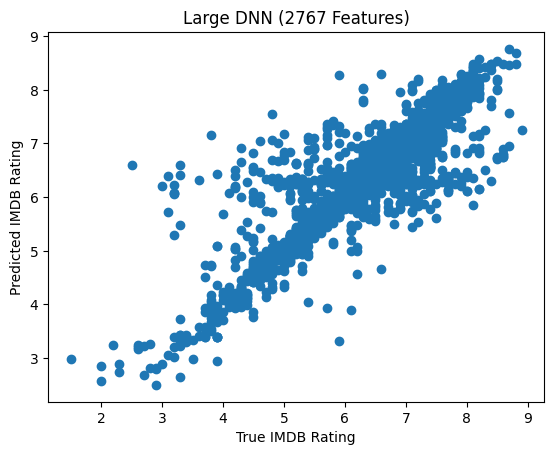

In [15]:
testPredictions = nn.predict(XtestScaledMS).flatten()
plt.scatter(ytestMS, testPredictions)
plt.xlabel('True IMDB Rating')
plt.ylabel('Predicted IMDB Rating')
plt.title('Large DNN (2767 Features)')